In [1]:
import gym
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from time import sleep
from IPython.display import display

In [2]:
env = gym.make("Taxi-v3").env
env.render()
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))
print('Blue colored letter denotes the pickup location and purple colored letter denotes the drop location.')

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)
Blue colored letter denotes the pickup location and purple colored letter denotes the drop location.


In [3]:
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)
env.s=state
env.render()

State: 328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [4]:
env.P[state]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

In [5]:
def brute_force(episodes):
    print("Running Brute Force....")
    performance_matrix=[]  
    frames=[]
    for episode in range(episodes):
        clear_output(wait=True)
        print(f"Progress: {(episode/episodes)*100}%")
        state=env.reset()
        epochs, penalties, reward, = 0, 0, 0
        done = False
        while not done:
            action = env.action_space.sample()
            state, reward, done, info = env.step(action)
            if reward == -10:
                penalties += 1
            
            frames.append({
                'episode': episode,
                'frame': env.render(mode='ansi'),
                'state': state,
                'action': action,
                'reward': reward
            })
            epochs += 1
        performance_matrix.append([epochs,penalties])
    return performance_matrix,frames

def q_learning(q_table,episodes):
    print("Running Q-Learning...")
    frames = [] 
    performance_matrix=[]
    for episode in range(episodes):
        clear_output(wait=True)
        print(f"Progress: {(episode/episodes)*100}%")
        state = env.reset()
        epochs, penalties, reward = 0, 0, 0
    
        done = False
    
        while not done:
            action = np.argmax(q_table[state])
            state, reward, done, info = env.step(action)

            frames.append({
            'frame': env.render(mode='ansi'),
            'episode':episode,
            'state': state,
            'action': action,
            'reward': reward
            }
            )

            if reward == -10:
                penalties += 1

            epochs += 1

        performance_matrix.append([epochs,penalties])
    return performance_matrix,frames


def print_frames(frames,sleep_time=0.1,**kwargs):
    if 'episode' in kwargs:
        frames=list(filter(lambda render: render['episode'] == kwargs['episode'], frames))
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Epsiode: {frame['episode']}")
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(sleep_time)



def plot_performance(title,performance_matrix,**kwargs):
    epochs=[]
    penalties=[]
    explore=[]
    exploit=[]
    for i,episode_performance in enumerate(performance_matrix):
        if 'interval' in kwargs:
            if i%kwargs['interval']==0:
                epochs.append(episode_performance[0])
                penalties.append(episode_performance[1])
        else:
            epochs.append(episode_performance[0])
            penalties.append(episode_performance[1])
    
    df=pd.DataFrame({'episodes': range(0,len(epochs)), 'epochs': epochs, 'penalties': penalties })
    plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    #plt.ylim(top=toplimit)
    if 'ylimit' in kwargs:
        plt.ylim(kwargs['ylimit'])
    if 'xlimit' in kwargs:
        plt.xlim(kwargs['xlimit'])
    if 'xlabel' in kwargs:
        plt.xlabel(kwargs['xlabel'])
    if 'ylabel' in kwargs:
        plt.ylabel(kwargs['ylabel'])
    plt.plot( 'episodes', 'epochs', data=df, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=4)
    plt.plot( 'episodes', 'penalties', data=df, marker='o', markerfacecolor='blue', markersize=1, color='olive', linewidth=4)
    plt.title(title)
    plt.legend()
    if 'save' in kwargs:
        plt.savefig(f"graphs/{kwargs['save']}")
    plt.show()


def q_learning_train(env,alpha=0.1,gamma=0.6,epsilon=0.5,iterations=5001,**kwargs):
    print(f"Running q_learning with alpha={alpha}, gamma={gamma}, epsilon={epsilon}, and {iterations-1} iterations")
    dh = display('',display_id=True)
    q_table = np.zeros([env.observation_space.n, env.action_space.n])
    #initialize the q-table as a 500 X 6 matrix of zeros as there are 500 states (5*5*5*4) and 6 actions
    all_epochs = []
    all_penalties = []
    q_learning_performance_matrix = []
    frames=[]
    for i in range(1, iterations):
        state = env.reset()

        epochs, penalties, reward = 0, 0, 0
        done = False
    
        while not done:

            if random.uniform(0, 1) < epsilon:
                action = np.argmax(q_table[state]) # Exploit learned values
            else:
                action = env.action_space.sample() # Explore action space

            next_state, reward, done, info = env.step(action) 
            frames.append({
            'frame': env.render(mode='ansi'),
            'episode':i,
            'state': state,
            'action': action,
            'reward': reward
            }
            )
        
            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])
        
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            if reward == -10:
                penalties += 1

            state = next_state
            epochs += 1
        q_learning_performance_matrix.append([epochs,penalties])
        if i % 100 == 0:
            #clear_output(wait=True)
            dh.update(f"Episode: {i}")

    print("Training finished.\n")
    return iterations,frames,q_table,q_learning_performance_matrix

def get_performance_df(performance_matrix):
    total=len(performance_matrix)
    sum_epochs,sum_penalties=0,0
    for metric in performance_matrix:
        sum_epochs+=metric[0]
        sum_penalties+=metric[1]
    return [sum_epochs/total,sum_penalties/total]

Running q_learning with alpha=0.4, gamma=0.999, epsilon=0.5, and 5000 iterations


'Episode: 5000'

Training finished.



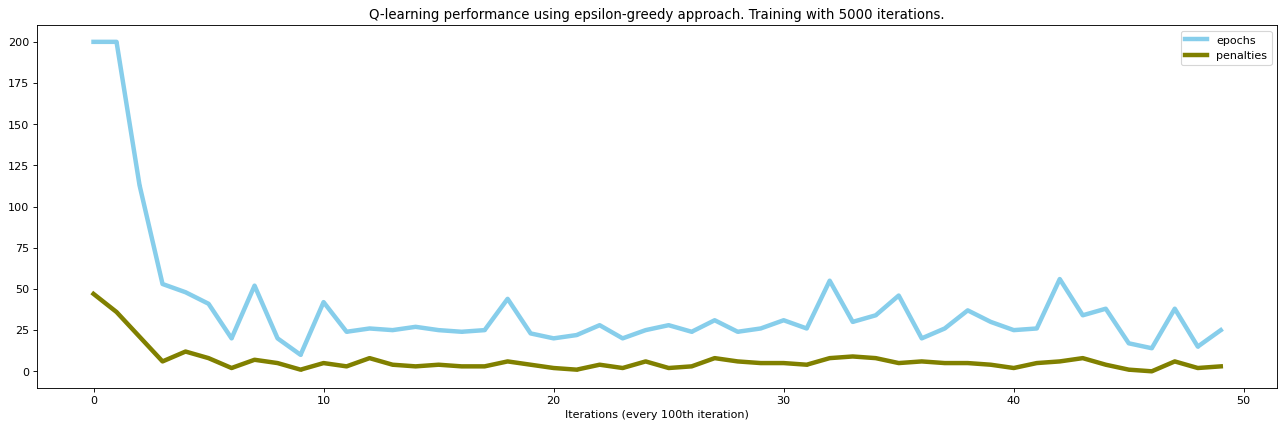

An agent using Q Learning Greedy takes about an average of 56 steps to successfully complete its mission.


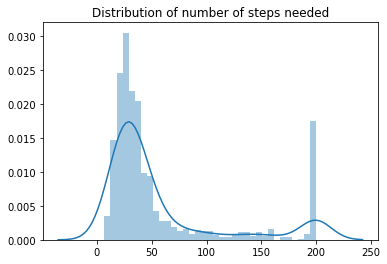

In [19]:
iterations,q_learning_frame_greedy,q_table_greedy,q_learning_performance_matrix_greedy=q_learning_train(env,alpha=0.4,gamma=0.999)
title1 = f"Q-learning performance using epsilon-greedy approach. Training with {iterations-1} iterations."
interval=100
plot_performance(title1,q_learning_performance_matrix_greedy,xlabel=f"Iterations (every {interval}th iteration)",interval=interval,save='epsilon-learning_newparam.png')

q_learning_greedy_epoch_count = []
for i in range(1000):
    q_learning_greedy_epoch_count.append(q_learning_performance_matrix_greedy[i][0])
    
sns.distplot(q_learning_greedy_epoch_count)
plt.title("Distribution of number of steps needed")

print("An agent using Q Learning Greedy takes about an average of " + str(int(np.mean(q_learning_greedy_epoch_count)))
      + " steps to successfully complete its mission.")
#as epsilon increases we explore more and exploit less and vice versa
#epsilon = 0.1 means explore, epsilon=0.9 means exploit

Running q_learning with alpha=0.4, gamma=0.999, epsilon=0.9, and 5000 iterations


'Episode: 5000'

Training finished.



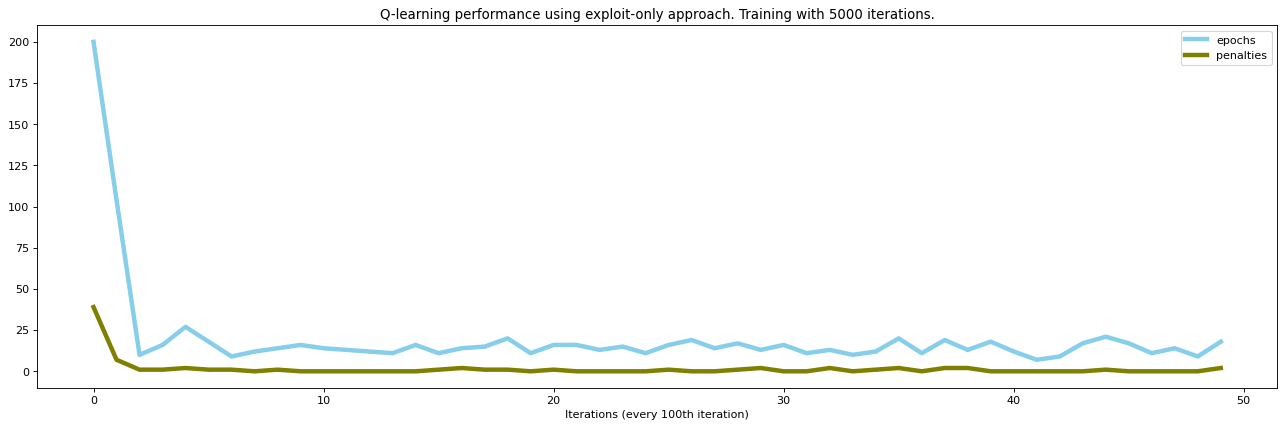

An agent using Q Learning Exploit takes about an average of 39 steps to successfully complete its mission.


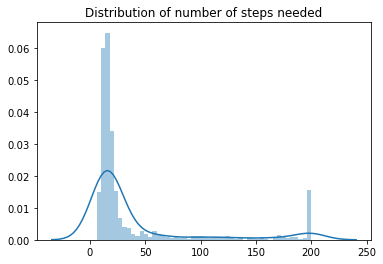

In [20]:
iterations,q_learning_frame_exploit,q_table_exploit,q_learning_performance_matrix_exploit=q_learning_train(env,alpha=0.4,gamma=0.999,epsilon=0.9)
title1 = f"Q-learning performance using exploit-only approach. Training with {iterations-1} iterations."
interval=100
plot_performance(title1,q_learning_performance_matrix_exploit,xlabel=f"Iterations (every {interval}th iteration)",interval=interval,save='exploit-only_newparam.png')

q_learning_exploit_epoch_count = []
for i in range(1000):
    q_learning_exploit_epoch_count.append(q_learning_performance_matrix_exploit[i][0])
    
sns.distplot(q_learning_exploit_epoch_count)
plt.title("Distribution of number of steps needed")

print("An agent using Q Learning Exploit takes about an average of " + str(int(np.mean(q_learning_exploit_epoch_count)))
      + " steps to successfully complete its mission.")

Running q_learning with alpha=0.4, gamma=0.999, epsilon=0.1, and 5000 iterations


'Episode: 5000'

Training finished.



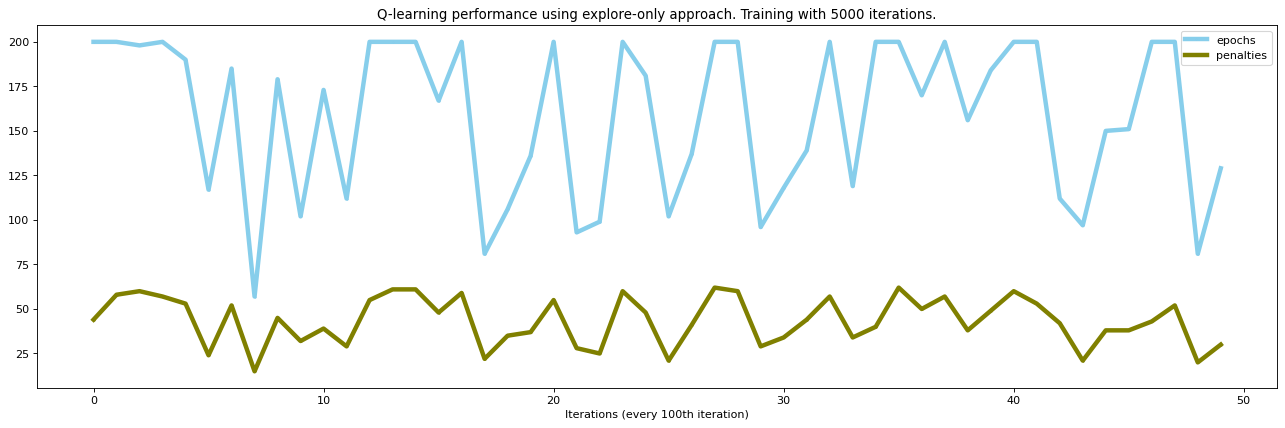

An agent using Q Learning Explore takes about an average of 166 steps to successfully complete its mission.


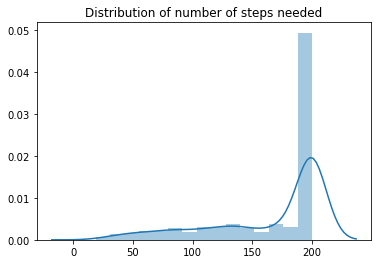

In [21]:
iterations,q_learning_frame_explore,q_table_explore,q_learning_performance_matrix_explore=q_learning_train(env,alpha=0.4,gamma=0.999,epsilon=0.1)
title1 = f"Q-learning performance using explore-only approach. Training with {iterations-1} iterations."
interval=100
plot_performance(title1,q_learning_performance_matrix_explore,xlabel=f"Iterations (every {interval}th iteration)",interval=interval,save='explore-only_newparam.png')

q_learning_explore_epoch_count = []
for i in range(1000):
    q_learning_explore_epoch_count.append(q_learning_performance_matrix_explore[i][0])
    
sns.distplot(q_learning_explore_epoch_count)
plt.title("Distribution of number of steps needed")

print("An agent using Q Learning Explore takes about an average of " + str(int(np.mean(q_learning_explore_epoch_count)))
      + " steps to successfully complete its mission.")

In [9]:
# performance_matrix_b,frames_brute_force=brute_force(iterations)

An agent using Random search takes about an average of 2487 steps to successfully complete its mission.


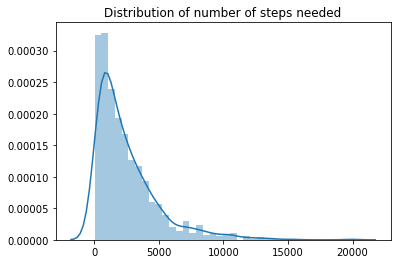

In [9]:
# Random Search 
env = gym.make("Taxi-v3")
env.s = 328
random_policy = np.ones([env.env.nS, env.env.nA]) / env.env.nA
def random_policy_steps_count():
    state = env.reset()
    counter = 0
    reward = None
    while reward != 20:
        state, reward, done, info = env.step(env.action_space.sample())  
        counter += 1
    return counter

random_search_epoch_count = [random_policy_steps_count() for i in range(1000)]
sns.distplot(random_search_epoch_count)
plt.title("Distribution of number of steps needed")

print("An agent using Random search takes about an average of " + str(int(np.mean(random_search_epoch_count)))
      + " steps to successfully complete its mission.")

In [10]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()/2
                value = int(p.get_width())
                ax.text(_x, _y, value ,va="center", ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

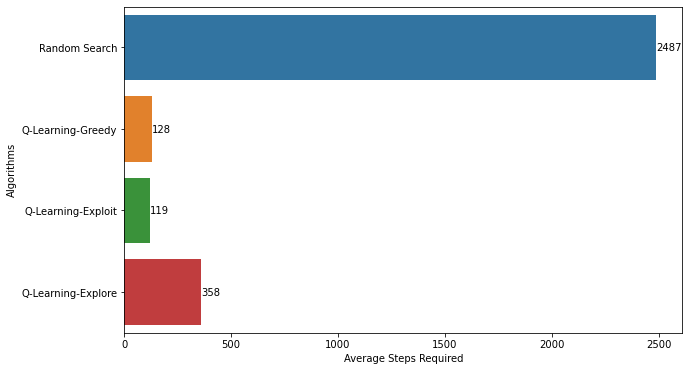

In [13]:
list1 = ['Random Search','Q-Learning-Greedy','Q-Learning-Exploit','Q-Learning-Explore']
list2 = []
list2.append(int(np.mean(random_search_epoch_count)))
list2.append(int(np.mean(q_learning_greedy_epoch_count)))
list2.append(int(np.mean(q_learning_exploit_epoch_count)))
list2.append(int(np.mean(q_learning_explore_epoch_count)))

df = pd.DataFrame(list(zip(list1, list2)), 
               columns =['Algorithms', 'Average Steps Required']) 
df
plt.figure(figsize=(10, 6))
ax = sns.barplot(y="Algorithms", x="Average Steps Required", data=df)
show_values_on_bars(ax, "h", 0.5)

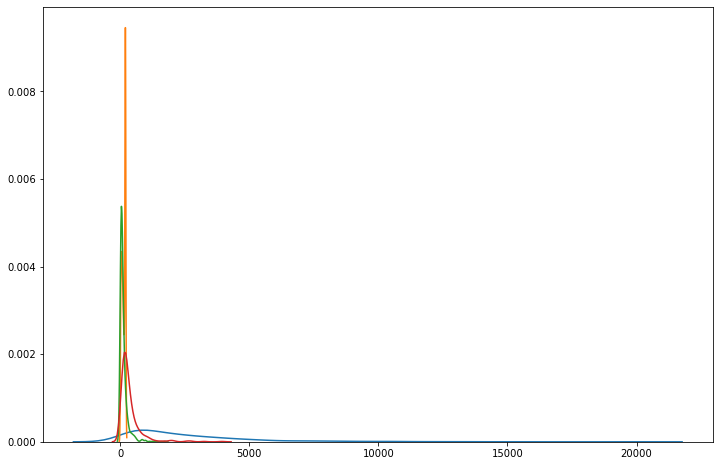

In [14]:
# sns.set(font_scale=1)
plt.figure(figsize=(12, 8))
sns.distplot(random_search_epoch_count, hist=False, rug=False)
sns.distplot(q_learning_greedy_epoch_count, hist=False, rug=False)
sns.distplot(q_learning_exploit_epoch_count, hist=False, rug=False)
sns.distplot(q_learning_explore_epoch_count, hist=False, rug=False)


In [16]:
# Random Search 
env = gym.make("Taxi-v3")
env.s = 328
random_policy = np.ones([env.env.nS, env.env.nA]) / env.env.nA
def random_policy_steps_count():
    state = env.reset()
    counter = 0
    reward = None
    penalties = 0
    while reward != 20:
        state, reward, done, info = env.step(env.action_space.sample())  
        counter += 1
        if reward == -10:
            penalties += 1
    return counter,penalties

performance_matrix_rs = [random_policy_steps_count() for i in range(5000)]

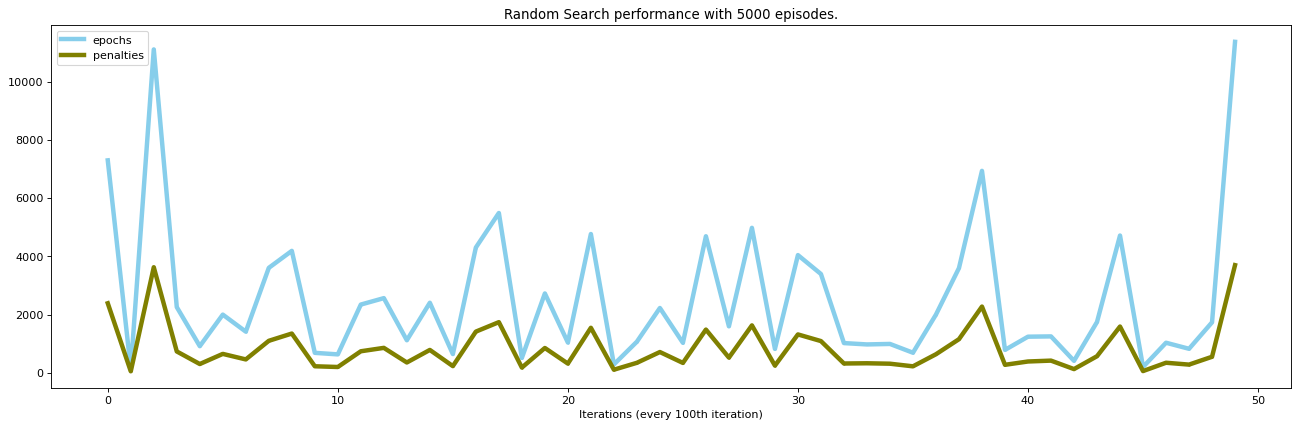

In [17]:
title1 = f"Random Search performance with 5000 episodes."
interval=100
plot_performance(title1,performance_matrix_rs,xlabel=f"Iterations (every {interval}th iteration)",interval=interval,save='random-search.png')

In [18]:
data = [get_performance_df(performance_matrix_rs),get_performance_df(q_learning_performance_matrix_greedy),get_performance_df(q_learning_performance_matrix_exploit),get_performance_df(q_learning_performance_matrix_explore)]
df = pd.DataFrame(data,index=['Random Search','Q-Learning-Greedy','Q-Learning-Exploit','Q-Learning-Explore'],columns=['Average epochs','Average penalties'])
print(f"Average for {5000} episodes/iterations")
df

Average for 5000 episodes/iterations


,Average epochs,Average penalties
Random Search,2519.9730,815.5224
Q-Learning-Greedy,54.4146,8.5604
Q-Learning-Exploit,38.7876,1.4156
Q-Learning-Explore,247.5218,70.4168
